In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import random as rd
import sys

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
x, y = pp.read_dataset('x_train.txt', 'y_train.txt')
len(x)

100000

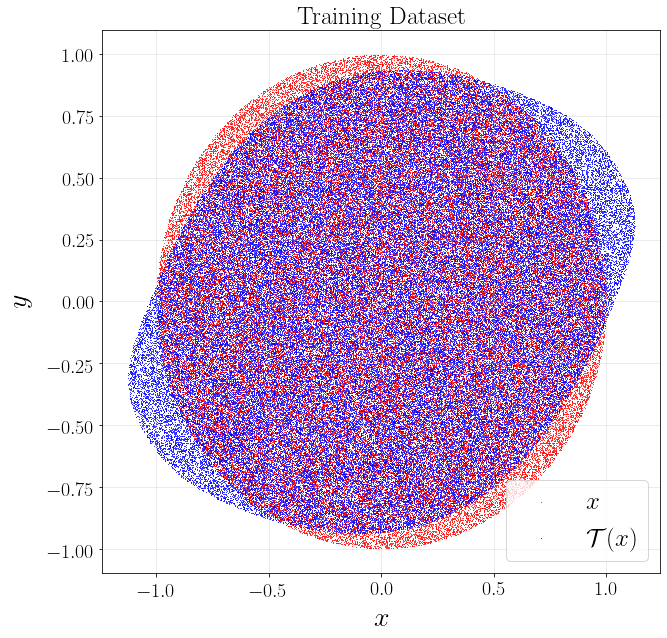

In [3]:
pp.plot_dataset(x, y)

In [84]:
train_dataset, val_dataset = pp.train_dataset(x, y, 10000, 70000, 10000) #val_len, train_batch, val_batch

In [85]:
class MLP(tf.keras.layers.Layer):
    
    def __init__(self, num_layers, **kwargs):

        super(MLP, self).__init__(**kwargs)
        self.num_layers = num_layers


    def build(self, input_shape):
        
        self.L1 = tf.keras.layers.Dense(10, activation='tanh')
        self.L2 = tf.keras.layers.Dense(20, activation='selu')
        self.L3 = tf.keras.layers.Dense(20, activation='selu')
        self.L4 = tf.keras.layers.Dense(2, activation='selu')


    def call(self, inputs, training=False):
        
        h = self.L1(inputs)
        h = self.L2(h)
        h = self.L3(h)
        h = self.L4(h)

        
        #h = self.conv_1(inputs)
        #h = self.bn_1(h)
        #h = self.conv_2(h)
        #h = self.bn_2(h)
        
        return h #+ inputs

In [86]:
def get_shift_and_log_scale_resnet(input_shape, blocks):
    
    inputs = tf.keras.Input(shape=input_shape)
    h = inputs

    for block in blocks:
        h = block(h)

    shift, log_scale = h, h #tf.split(h, num_or_size_splits=2, axis=-1)
    log_scale = tf.math.tanh(log_scale)
    return Model(inputs=inputs, outputs=[shift, log_scale], name='name')

In [87]:
class AffineCouplingLayer(layers.Layer):

    def __init__(self, shift_and_log_scale_fn, mask):
        
        super(AffineCouplingLayer, self).__init__()
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.b = tf.cast(mask, tf.float32)

    def call(self, x, inverse):
        
        if inverse == 1:
            t, log_s = self.shift_and_log_scale_fn(x * self.b)
            y = self.b * x + (1 - self.b) * (x * tf.exp(log_s) + t)
            return y
        
        if inverse == 0:
            t, log_s = self.shift_and_log_scale_fn(x * self.b)
            y = self.b * x + (1 - self.b) * ((x - t) * tf.exp(-log_s))
            return y

In [88]:
class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
        return inputs*tf.constant([[1., -1.]])

In [89]:
class RealNVPModel(tf.keras.Model):
    
    def __init__(self, shift_and_log_scale, **kwargs):
        
        super(RealNVPModel, self).__init__()
        self.R = R()
        masks = []
        self.l = []
        
        for j in range(len(shift_and_log_scale)):
            
            if j%2==0:
                masks.append(tf.constant([[0., 1.]]))
            else:
                masks.append(tf.constant([[1., 0.]]))

        
        for i,j in zip(shift_and_log_scale, masks):
            self.l.append(AffineCouplingLayer(i, j))
        
        #self.acl1 = AffineCouplingLayer(shift_and_log_scale[0], mask)
        #self.acl2 = AffineCouplingLayer(shift_and_log_scale[1], mask1)
        #self.acl3 = AffineCouplingLayer(shift_and_log_scale[2], mask)
        #self.acl4 = AffineCouplingLayer(shift_and_log_scale[3], mask1)
        #self.acl5 = AffineCouplingLayer(shift_and_log_scale[4], mask)
        #self.acl6 = AffineCouplingLayer(shift_and_log_scale[5], mask1)

    def call(self, input_tensor):
        
        a = self.R(input_tensor)
        
        for layer in self.l:
            a = layer(a, 1)

        a = self.R(a)

        for layer in self.l[::-1]:
            a = layer(a, 0)
        
        
        #a = self.acl1(a, 1)
        #a = self.acl2(a, 1)
        #a = self.acl3(a, 1)
        #a = self.acl4(a, 1)
        #a = self.acl5(a, 1)
        #a = self.acl6(a, 1)
        
        #a = self.R(a)

        #a = self.acl6(a, 0)
        #a = self.acl5(a, 0)
        #a = self.acl4(a, 0)
        #a = self.acl3(a, 0)
        #a = self.acl2(a, 0)
        #a = self.acl1(a, 0)
        
        return a

In [90]:
blocks = [MLP(10, name='MLP1'),
MLP(10, name='MLP2'),
MLP(10, name='MLP3'),
MLP(10, name='MLP4'),
MLP(10, name='MLP5'),
MLP(10, name='MLP6')]

shift_and_log_scale = [get_shift_and_log_scale_resnet((2), [i]) for i in blocks]

In [91]:
shift_and_log_scale[0].summary()

Model: "name"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
MLP1 (MLP)                   (None, 2)                 712       
_________________________________________________________________
tf.math.tanh_50 (TFOpLambda) (None, 2)                 0         
Total params: 712
Trainable params: 712
Non-trainable params: 0
_________________________________________________________________


In [92]:
model = RealNVPModel(shift_and_log_scale)

In [93]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch < 5:
        print(lr)
        return lr
    else:
        #print(lr)
        return lr*tf.math.exp(-0.0001)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [94]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=tf.keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [95]:
history = model.fit(train_dataset, epochs = 100, callbacks = [callback], verbose=1) #np.array(x), [np.array(y),a,a]

Epoch 1/100
0.0010000000474974513
2/2 [==============================] - 2s 77ms/step - loss: 10.7551 - accuracy: 0.6658
Epoch 2/100
0.0010000000474974513
2/2 [==============================] - 0s 74ms/step - loss: 2.9950 - accuracy: 0.6115
Epoch 3/100
0.0010000000474974513
2/2 [==============================] - 0s 75ms/step - loss: 2.6993 - accuracy: 0.5942
Epoch 4/100
0.0010000000474974513
2/2 [==============================] - 0s 74ms/step - loss: 1.8583 - accuracy: 0.5929
Epoch 5/100
0.0010000000474974513
2/2 [==============================] - 0s 77ms/step - loss: 1.0737 - accuracy: 0.5963
Epoch 6/100
2/2 [==============================] - 0s 76ms/step - loss: 0.7319 - accuracy: 0.6008
Epoch 7/100
2/2 [==============================] - 0s 77ms/step - loss: 0.5963 - accuracy: 0.6067
Epoch 8/100
2/2 [==============================] - 0s 74ms/step - loss: 0.5416 - accuracy: 0.6111
Epoch 9/100
2/2 [==============================] - 0s 76ms/step - loss: 0.5029 - accuracy: 0.6116
Epoch 1

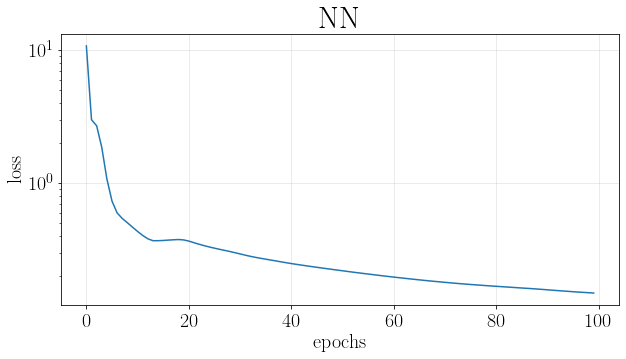

In [96]:
plt.figure(figsize = (10,5))
#plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

In [97]:
x0 = np.array([[rd.randrange(-100, 100, 1)*0.001, rd.randrange(-100, 100, 1)*0.001] for _ in range(10)])

f_iterations = [model(x0)]

In [98]:
for _ in range(100):
    f_iterations.append(model(f_iterations[-1]))

b_iterations = [f_iterations[-1]*np.array([[1., -1.]])]

for _ in range(100):
    b_iterations.append(model(b_iterations[-1]))

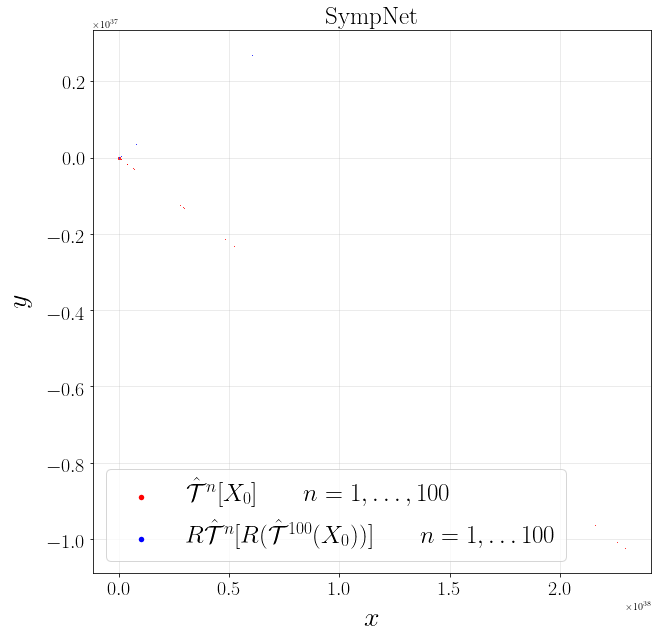

In [99]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 25)


plt.scatter(*zip(*f_iterations[0].numpy()), s=5, linewidth=0, color='r', label= r'$\hat{\mathcal{T}}^{n}[X_{0}] \qquad n=1,\dots ,100$')

for i in f_iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color='r')
    
#plt.scatter(*zip(*f_iterations[-1].numpy()), s=15, linewidth=0, color='r')

#plt.scatter(*zip(*b_iterations[0].numpy()), s=15, linewidth=0, color='b')

b_iterations_symm = b_iterations*np.array([[1., -1.]])

plt.scatter(*zip(*b_iterations_symm[0]), s=1, linewidth=0, color='b', label= r'$R \hat{\mathcal{T}}^{n}[R(\hat{\mathcal{T}}^{100}(X_{0}))] \qquad n=1,\dots 100$')

for i in b_iterations_symm:
    plt.scatter(*zip(*i), s=1, linewidth=0, color='b')

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(scatterpoints=1, fontsize=25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
#plt.savefig("Testing_Reversinility_NonReversible.png")
plt.show()